In [ ]:
# -*- coding: utf-8 -*-
"""
bccd.ipynb: Automatically generated by Colab - Customized!
Original file is located at: https://colab.research.google.com/drive/1vme1jryl4LhO9JVjGSO8CddH3bFhjO-w
"""
# Install dataset
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [ ]:
# Extraction of data labels from .xml file to dataframe
import os
import shutil
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import KFold
from sklearn import preprocessing, model_selection

annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

df = []
cnt = 0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(node.find('bndbox/xmin').text)
    xmax = int(node.find('bndbox/xmax').text)
    ymin = int(node.find('bndbox/ymin').text)
    ymax = int(node.find('bndbox/ymax').text)

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
    df.append(row)
  cnt += 1

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection.csv', index=False)

img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df = pd.read_csv('/content/blood_cell_detection.csv')

le = preprocessing.LabelEncoder()
le.fit(df['cell_type'])
print(le.classes_)
labels = le.transform(df['cell_type'])
df['labels'] = labels

df['width'] = df.apply(width, axis=1)
df['height'] = df.apply(height, axis=1)

df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df['x_center'].apply(w_norm)
df['width_norm'] = df['width'].apply(w_norm)

df['y_center_norm'] = df['y_center'].apply(h_norm)
df['height_norm'] = df['height'].apply(h_norm)


['Platelets' 'RBC' 'WBC']


In [3]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)

  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path, str(row.prev_filename.split('.')[0]) + ".txt")
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path, row.prev_filename), os.path.join(train_img_path, row.prev_filename))

In [ ]:
# Install dependencies adn YOLOv5
!git clone 'https://github.com/ultralytics/yolov5.git'
!pip install -qr '/content/yolov5/requirements.txt'
# %pip install -qr '/content/yolov5/requirements.txt'

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.12 MiB | 31.14 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB

In [5]:
%cd /content/yolov5

/content/yolov5


In [ ]:
# CBAM Kodunu YOLOv5'in common.py dosyasına ekleyelim
cbam_code = """
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x
"""

# common.py dosyasına ekleyelim
common_py_path = "/content/yolov5/models/common.py"

with open(common_py_path, "a") as f:  # "a" ekleme modunda açar
    f.write(cbam_code)

print("CBAM code, integrated in models/common.py file successfully!")


CBAM kodu models/common.py dosyasına başarıyla eklendi!


In [ ]:
# yolov5l.yaml dosyasını CBAM ile güncelle
yolov5l_yaml_path = "/content/yolov5/models/yolov5l.yaml"

# Model dosyasını oku
with open(yolov5l_yaml_path, "r") as f:
    yolov5l_yaml = f.readlines()

# Conv yerine CBAM ekle
updated_yaml = []
for line in yolov5l_yaml:
    if "module: Conv" in line:  # Conv modülünü CBAM ile değiştir
        updated_yaml.append(line.replace("module: Conv", "module: CBAM"))
    else:
        updated_yaml.append(line)

# Yeni dosyayı kaydet
with open(yolov5l_yaml_path, "w") as f:
    f.writelines(updated_yaml)

print("CBAM model, integrated in models/yolov5l.yaml file successfully!")


CBAM modeli models/yolov5l.yaml dosyasına başarıyla entegre edildi!


In [8]:
!tail -n 20 /content/yolov5/models/common.py

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


In [9]:
%cd /content/

/content


In [ ]:
# === K-Fold Cross Validation Integration ===
import os
import pandas as pd
from sklearn.model_selection import KFold

# Ensure DataFrame has enough data
if len(df) < 2:
    raise ValueError(f"Insufficient data: {len(df)} samples found. At least 2 are required.")

# Disable wandb
os.environ['WANDB_MODE'] = 'disabled'

# shuffle=False, random_state=None -> used
# shuffle=True, random_state=42 -> NOT used
kf = KFold(n_splits=5, shuffle=False, random_state=None)
fold_results = []

for fold, (train_index, valid_index) in enumerate(kf.split(df)):
    print(f"\n=== Fold {fold + 1} ===")

    # Eğitim ve doğrulama veri setlerini ayırma
    train_df = df.iloc[train_index]
    valid_df = df.iloc[valid_index]

    # Eğitim ve doğrulama dosyalarını hazırlama
    train_img_path = f"/content/bcc/images/train/fold_{fold}"
    valid_img_path = f"/content/bcc/images/valid/fold_{fold}"
    train_label_path = f"/content/bcc/labels/train/fold_{fold}"
    valid_label_path = f"/content/bcc/labels/valid/fold_{fold}"

    # Klasör oluşturma
    os.makedirs(train_img_path, exist_ok=True)
    os.makedirs(valid_img_path, exist_ok=True)
    os.makedirs(train_label_path, exist_ok=True)
    os.makedirs(valid_label_path, exist_ok=True)

    # Veriyi klasörlere ayırma
    segregate_data(train_df, "/content/BCCD_Dataset/BCCD/JPEGImages/",
                   "/content/BCCD_Dataset/BCCD/Annotations/",
                   train_img_path, train_label_path)
    segregate_data(valid_df, "/content/BCCD_Dataset/BCCD/JPEGImages/",
                   "/content/BCCD_Dataset/BCCD/Annotations/",
                   valid_img_path, valid_label_path)

    # YOLOv5 için eğitim dosyasını oluşturma
    yolo_data_yaml = f'bcc_fold_{fold}.yaml'
    with open(yolo_data_yaml, 'w') as f:
        f.write(f"train: {train_img_path}\n")
        f.write(f"val: {valid_img_path}\n\n")
        f.write("nc: 3\n")  # Sınıf sayısı
        f.write("names: ['Platelets', 'RBC', 'WBC']\n")

    # YOLOv5 Modelini Eğitme
    print(f"\nTraining starts (Fold {fold + 1})...")
    !python yolov5/train.py --img 640 --batch 16 --epochs 100 --data {yolo_data_yaml} --cfg /content/yolov5/models/yolov5l.yaml --name BCCM_fold_{fold}

    # Fold sonuçlarını değerlendirme
    print(f"\nTraining completed for Fold {fold + 1}.")

    # Eğitim sonuçlarını okuma
    results_file = f'yolov5/runs/train/BCCM_fold_{fold}/results.csv'
    print(os.listdir(f'yolov5/runs/train/BCCM_fold_{fold}/'))

    if os.path.exists(results_file):
        results = pd.read_csv(results_file)
        print(f"Columns in Fold {fold + 1}: {results.columns.tolist()}")
        results.columns = results.columns.str.strip()
        last_epoch_results = results.iloc[-1]

        # Column names from results.csv
        precision = last_epoch_results.get("metrics/precision", None)
        recall = last_epoch_results.get("metrics/recall", None)

        mAP50 = last_epoch_results.get("metrics/mAP_0.5", None)
        mAP5095 = last_epoch_results.get("metrics/mAP_0.5:0.95", None)

        if None not in [precision, recall, mAP50, mAP5095]:
            fold_results.append({
                'fold': fold + 1,
                'precision': precision,
                'recall': recall,
                'mAP50': mAP50,
                'mAP50-95': mAP5095
            })
            print(f"Fold {fold + 1} - Precision: {precision}, Recall: {recall}, mAP@0.5: {mAP50}, mAP@0.5:0.95: {mAP5095}")
        else:
            print(f"Some metrics are missing in Fold {fold + 1} results.")
    else:
        print(f"Results file not found for Fold {fold + 1}.")

# Calculate and display averages
if fold_results:
    results_df = pd.DataFrame(fold_results)
    avg_precision = results_df['precision'].mean()
    avg_recall = results_df['recall'].mean()
    avg_map50 = results_df['mAP50'].mean()
    avg_map5095 = results_df['mAP50-95'].mean()
    
    print("\n=== Final Cross-Validation Results ===")
    print(f"Overall Average Precision: {avg_precision:.4f}")
    print(f"Overall Average Recall: {avg_recall:.4f}")
    print(f"Overall Average mAP@0.5: {avg_map50:.4f}")
    print(f"Overall Average mAP@0.5:0.95: {avg_map5095:.4f}")
else:
    print("No results available for averages.")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  with torch.cuda.amp.autocast(amp):
      86/99      10.5G    0.03043     0.1363   0.001982        371        640:   6% 1/18 [00:00<00:02,  6.24it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      86/99      10.5G    0.03086     0.1501   0.001403        443        640:  11% 2/18 [00:00<00:02,  6.61it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      86/99      10.5G    0.03109      0.144    0.00158        360        640:  17% 3/18 [00:00<00:02,  6.80it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      8

In [11]:
!ls /content/yolov5/runs/train/

BCCM_fold_0  BCCM_fold_1  BCCM_fold_2  BCCM_fold_3  BCCM_fold_4


In [ ]:
# YOLOv5 Summary for each fold from the training
for fold in range(5):
    !python /content/yolov5/val.py --weights /content/yolov5/runs/train/BCCM_fold_{fold}/weights/best.pt --data bcc_fold_{fold}.yaml


val: data=bcc_fold_0.yaml, weights=['/content/yolov5/runs/train/BCCM_fold_0/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /content/bcc/labels/valid/fold_0.cache... 51 images, 0 backgrounds, 0 corrupt: 100% 51/51 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:01<00:00,  1.09it/s]
                   all         51        978      0.827      0.816      0.889      0.539
             Platelets         51         72      0.688      0.857      0.845     

In [ ]:
import os
import pandas as pd

# Array for each Fold results
fold_results = []

# 5 Fold 
for fold in range(5):
    results_file = f"/content/yolov5/runs/train/BCCM_fold_{fold}/results.csv"
    file_exists = os.path.exists

    if file_exists(results_file):
        results = pd.read_csv(results_file)

        # Sütun isimlerindeki boşlukları temizle
        results.columns = results.columns.str.strip()

        # Sütun isimlerini ekrana yazdır (Kontrol amaçlı)
        print(f"\nFold {fold} - Columns:", results.columns.tolist())

        # Son epoch'un sonuçlarını al
        last_epoch_results = results.iloc[-1]  # Son satır (son epoch)

        # Precision, Recall ve mAP değerlerini al
        precision = last_epoch_results["metrics/precision"]
        recall = last_epoch_results["metrics/recall"]
        mAP50 = last_epoch_results["metrics/mAP_0.5"]
        mAP50_95 = last_epoch_results["metrics/mAP_0.5:0.95"]

        # Fold sonuçlarını sakla
        fold_results.append({
            "fold": fold,
            "Precision": precision,
            "Recall": recall,
            "mAP@0.5": mAP50,
            "mAP@0.5:0.95": mAP50_95
        })
    else:
        print(f"Error: {results_file} not found!")

# Eğer en az 1 fold sonucu varsa ortalamaları hesapla
if fold_results:
    results_df = pd.DataFrame(fold_results)

    # Ortalama Precision, Recall ve mAP değerlerini hesapla
    avg_precision = results_df["Precision"].mean()
    avg_recall = results_df["Recall"].mean()
    avg_mAP50 = results_df["mAP@0.5"].mean()
    avg_mAP50_95 = results_df["mAP@0.5:0.95"].mean()

    # Sonuçları göster
    print("\n=== Final Cross-Validation Results ===")
    print(f"Overall Average Precision: {avg_precision:.4f}")
    print(f"Overall Average Recall: {avg_recall:.4f}")
    print(f"Overall Average mAP@0.5: {avg_mAP50:.4f}")
    print(f"Overall Average mAP@0.5:0.95: {avg_mAP50_95:.4f}")
else:
    print("No overall average found!")




Fold 0 - Sütunlar: ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']

Fold 1 - Sütunlar: ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']

Fold 2 - Sütunlar: ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']

Fold 3 - Sütunlar: ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']

Fold 4 - Sütunlar: ['epoch', 'train

In [ ]:
import pandas as pd

# CSV dosyasının yolunu belirle
csv_path = "/content/yolov5/runs/train/BCCM_fold_0/results.csv"

# CSV'yi oku
results = pd.read_csv(csv_path)

# Sütun isimlerindeki gereksiz boşlukları temizle
results.columns = results.columns.str.strip()

# Temizlenmiş sütunları ekrana yazdır
print("Cleaned column names:")
print(results.columns.tolist())

Temizlenmiş sütun isimleri:
['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']


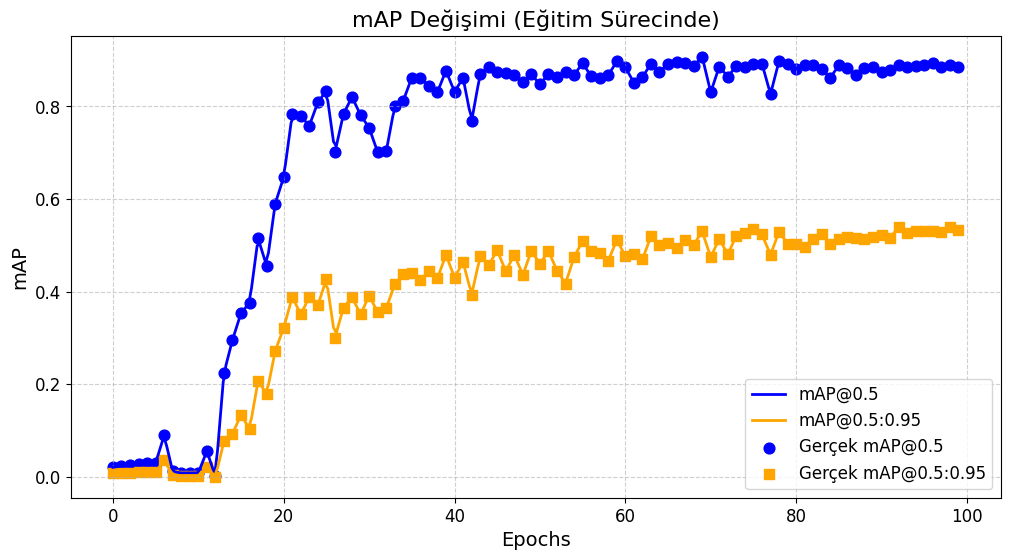

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Epoch ve mAP değerlerini al
epochs = results["epoch"]
mAP_50 = results["metrics/mAP_0.5"]
mAP_50_95 = results["metrics/mAP_0.5:0.95"]

# Eğriyi düzgün göstermek için interpolasyon ekleyelim (daha smooth çizgi)
smooth_epochs = np.linspace(min(epochs), max(epochs), 300)  # Daha fazla nokta oluştur
smooth_map_50 = np.interp(smooth_epochs, epochs, mAP_50)  # Değerleri interpolasyon ile yumuşat
smooth_map_50_95 = np.interp(smooth_epochs, epochs, mAP_50_95)

# Grafik çizimi
plt.figure(figsize=(12, 6))  # Genişliği artır (12x6 boyutunda)
plt.plot(smooth_epochs, smooth_map_50, label="mAP@0.5", color="blue", linewidth=2)
plt.plot(smooth_epochs, smooth_map_50_95, label="mAP@0.5:0.95", color="orange", linewidth=2)

# Noktaları belirginleştirmek için scatter ekleyelim
plt.scatter(epochs, mAP_50, color="blue", marker="o", s=60, label="Real mAP@0.5")
plt.scatter(epochs, mAP_50_95, color="orange", marker="s", s=60, label="Real mAP@0.5:0.95")

# Eksen etiketleri ve başlık
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("mAP", fontsize=14)
plt.legend(fontsize=12)
plt.title("mAP Change (During Training)", fontsize=16)

# Daha belirgin eksen çizgileri ekleyelim
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Izgara ekleyelim
plt.grid(True, linestyle="--", alpha=0.6)

# Grafiği göster
plt.show()

